# Part-of-Speech and Sequence Annotation
A reimplementation of the Senna program described in [_Natural language processing (almost) from scratch_](https://arxiv.org/abs/1103.0398) by Collobert et al. (2011) with PyTorch.
## Part 1: Annotation with a Feed-Forward Network


__Author__: Pierre Nugues

## Python Headers

A few things to download

In [1]:
#!pip install conlleval
"""
!wget https://data.deepai.org/conll2003.zip
!unzip -u conll2003.zip
!mkdir datasets/conll2003
!mv train.txt valid.txt test.txt datasets/conll2003
!rm conll2003.zip
"""

'\n!wget https://data.deepai.org/conll2003.zip\n!unzip -u conll2003.zip\n!mkdir datasets/conll2003\n!mv train.txt valid.txt test.txt datasets/conll2003\n!rm conll2003.zip\n'

### The Modules

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report
import conlleval

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import ud_datasets
from conll_dictorizer import CoNLLDictorizer

### Some Parameters

The words to build the vocabulary and the embedding vectors:
* 0: Random embeddings: The embedding table contains only the words in the corpus. 
* 1: Senna embeddings only: The embedding table contains only the words in the embeddings vocabulary (Senna). All the other words share an `UNK` symbol and vector
* 2: Senna + word embeddings: We create an embedding table for the words in corpus and in Senna. We  initialize the embeddings with Senna vectors when available, otherwise random

In [3]:
USE_EMBEDDINGS = 2

In [4]:
CORPUS = 'CONLL2003'   # 'EWT' 'CONLL2003' 'CONLL2000'
TAGSET = 'IOBES'  # 'BIO' 'IOBES'

In [5]:
DATASET_PATH = 'datasets/'
MODEL_PATH = 'models/'

In [6]:
# The embedding files. You will possibly need to adjust the path
EMBEDDINGS_FILE = DATASET_PATH + 'senna/embeddings/embeddings.txt'
WORD_FILE = DATASET_PATH + 'senna/hash/words.lst'

In [7]:
EMBEDDING_DIM = 50
CAPS_EMBEDDING_DIM = 5
N_HU_1 = 300
MINI_CORPUS = False
LOWERCASE = True
D_WIN = 2  # Context to the right and left. Size of the window 2 * D_WIN + 1, d_win in Senna paper

In [8]:
EPOCHS = 25
LR = 0.01
BATCH_SIZE = 1

In [9]:
random.seed(1234)
torch.manual_seed(1234)

## Preprocessing

### Embeddings

In [10]:
def read_embeddings(word_file: str, embs_file: str) -> dict[str, torch.FloatTensor]:
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    embeddings = {}
    words = []
    with open(word_file) as f:
        for line in f:
            word = line.strip()
            words += [word]
    with open(embs_file) as f:
        for i, line in enumerate(f):
            values = line.strip().split()
            word = words[i]
            vector = torch.FloatTensor(
                list(map(float, values)))
            embeddings[word] = vector
    return embeddings

In [11]:
embeddings_dict = read_embeddings(WORD_FILE, EMBEDDINGS_FILE)
embedded_words = sorted(list(embeddings_dict.keys()))

### Loading the Corpus
Collobert et al. did not describe their validation experiments. In CoNLL 2000, there is no validation set. Although not a good practice, we use the test set to validate the training procedure. We also follow Attardi, https://github.com/attardi/deepnl, and we merge the CoNLL 2003 training and validation sets.

In [12]:
from datetime import datetime
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2025-03-02 21:08:01'

In [13]:
if CORPUS == 'EWT':
    train_sentences, val_sentences, test_sentences, column_names = ud_datasets.load_ud_en_ewt()
    MODEL_NAME = 'pos_model'
elif CORPUS == 'CONLL2003':
    train_file = DATASET_PATH + 'conll2003/train.txt'
    val_file = DATASET_PATH + 'conll2003/valid.txt'
    test_file = DATASET_PATH + 'conll2003/test.txt'
    with open(train_file) as f:
        train_sentences = f.read().strip()
    with open(val_file) as f:
        val_sentences = f.read().strip()
    with open(test_file) as f:
        test_sentences = f.read().strip()
    MODEL_NAME = 'ner_model'
    column_names = ['FORM', 'PPOS', 'PCHUNK', 'NER']
elif CORPUS == 'CONLL2000':
    train_file = DATASET_PATH + 'conll2000/train.txt'
    test_file = DATASET_PATH + 'conll2000/test.txt'
    with open(train_file) as f:
        train_sentences = f.read().strip()
    with open(test_file) as f:
        test_sentences = f.read().strip()
    column_names = ['FORM', 'PPOS', 'CHUNK']
    MODEL_NAME = 'chunker_model'

In [14]:
MODEL_FILE = MODEL_PATH + MODEL_NAME + '_' + \
    datetime.now().strftime('%Y-%m-%d %H:%M:%S') + '.pt'
MODEL_FILE

'models/ner_model_2025-03-02 21:08:01.pt'

### Experimental setup

We use the test set as validation set for CoNLL 2000 and 2003. We add the validation set to the training set in CoNLL 2003

In [15]:
if CORPUS == 'CONLL2003':
    train_sentences += '\n\n' + val_sentences
    val_sentences = test_sentences
if CORPUS == 'CONLL2000':
    val_sentences = test_sentences

## Dictorizing the corpus

We store the corpus word in a dictionary, where the keys are the CoNLL-U columns

In [16]:
if CORPUS == 'EWT':
    conll_dict = CoNLLDictorizer(column_names)
elif CORPUS == 'CONLL2003':
    conll_dict = CoNLLDictorizer(column_names, col_sep=' +')
elif CORPUS == 'CONLL2000':
    conll_dict = CoNLLDictorizer(column_names, col_sep=' +')

In [17]:
train_dict = conll_dict.transform(train_sentences)
val_dict = conll_dict.transform(val_sentences)
test_dict = conll_dict.transform(test_sentences)

In [18]:
train_dict[0][:10]

[{'FORM': '-DOCSTART-', 'PPOS': '-X-', 'PCHUNK': '-X-', 'NER': 'O'}]

In [19]:
train_dict[:3]

[[{'FORM': '-DOCSTART-', 'PPOS': '-X-', 'PCHUNK': '-X-', 'NER': 'O'}],
 [{'FORM': 'EU', 'PPOS': 'NNP', 'PCHUNK': 'B-NP', 'NER': 'B-ORG'},
  {'FORM': 'rejects', 'PPOS': 'VBZ', 'PCHUNK': 'B-VP', 'NER': 'O'},
  {'FORM': 'German', 'PPOS': 'JJ', 'PCHUNK': 'B-NP', 'NER': 'B-MISC'},
  {'FORM': 'call', 'PPOS': 'NN', 'PCHUNK': 'I-NP', 'NER': 'O'},
  {'FORM': 'to', 'PPOS': 'TO', 'PCHUNK': 'B-VP', 'NER': 'O'},
  {'FORM': 'boycott', 'PPOS': 'VB', 'PCHUNK': 'I-VP', 'NER': 'O'},
  {'FORM': 'British', 'PPOS': 'JJ', 'PCHUNK': 'B-NP', 'NER': 'B-MISC'},
  {'FORM': 'lamb', 'PPOS': 'NN', 'PCHUNK': 'I-NP', 'NER': 'O'},
  {'FORM': '.', 'PPOS': '.', 'PCHUNK': 'O', 'NER': 'O'}],
 [{'FORM': 'Peter', 'PPOS': 'NNP', 'PCHUNK': 'B-NP', 'NER': 'B-PER'},
  {'FORM': 'Blackburn', 'PPOS': 'NNP', 'PCHUNK': 'I-NP', 'NER': 'I-PER'}]]

Conversion of BIO to IOBES

In [20]:
def BIO2IOBES(sent_dicts: list[dict], tag='CHUNK'):
    for sent_dict in sent_dicts:
        for idx in range(len(sent_dict) - 1):
            # B O -> S O
            if sent_dict[idx][tag][0] == 'B' and sent_dict[idx + 1][tag][0] == 'O':
                sent_dict[idx][tag] = 'S' + sent_dict[idx][tag][1:]
            # B-NP B-VP -> E-NP B-VP
            elif sent_dict[idx][tag][0] == 'B' and sent_dict[idx + 1][tag][0] == 'B':
                sent_dict[idx][tag] = 'S' + sent_dict[idx][tag][1:]
            # I O -> E O
            elif sent_dict[idx][tag][0] == 'I' and sent_dict[idx + 1][tag][0] == 'O':
                sent_dict[idx][tag] = 'E' + sent_dict[idx][tag][1:]
            # I B -> E B
            elif sent_dict[idx][tag][0] == 'I' and sent_dict[idx + 1][tag][0] == 'B':
                sent_dict[idx][tag] = 'E' + sent_dict[idx][tag][1:]
            else:
                pass

        # Last word
        if sent_dict[-1][tag][0] == 'B':
            sent_dict[-1][tag] = 'S' + sent_dict[-1][tag][1:]
        elif sent_dict[-1][tag][0] == 'I':
            sent_dict[-1][tag] = 'E' + sent_dict[-1][tag][1:]
        else:
            pass
    return sent_dicts

In [21]:
if TAGSET == 'IOBES' and CORPUS in ['CONLL2000', 'CONLL2003']:
    if CORPUS == 'CONLL2000':
        tag = 'CHUNK'
    elif CORPUS == 'CONLL2003':
        tag = 'NER'
    train_dict = BIO2IOBES(train_dict, tag)
    val_dict = BIO2IOBES(val_dict, tag)
    test_dict = BIO2IOBES(test_dict, tag)

In [22]:
train_dict[:4]

[[{'FORM': '-DOCSTART-', 'PPOS': '-X-', 'PCHUNK': '-X-', 'NER': 'O'}],
 [{'FORM': 'EU', 'PPOS': 'NNP', 'PCHUNK': 'B-NP', 'NER': 'S-ORG'},
  {'FORM': 'rejects', 'PPOS': 'VBZ', 'PCHUNK': 'B-VP', 'NER': 'O'},
  {'FORM': 'German', 'PPOS': 'JJ', 'PCHUNK': 'B-NP', 'NER': 'S-MISC'},
  {'FORM': 'call', 'PPOS': 'NN', 'PCHUNK': 'I-NP', 'NER': 'O'},
  {'FORM': 'to', 'PPOS': 'TO', 'PCHUNK': 'B-VP', 'NER': 'O'},
  {'FORM': 'boycott', 'PPOS': 'VB', 'PCHUNK': 'I-VP', 'NER': 'O'},
  {'FORM': 'British', 'PPOS': 'JJ', 'PCHUNK': 'B-NP', 'NER': 'S-MISC'},
  {'FORM': 'lamb', 'PPOS': 'NN', 'PCHUNK': 'I-NP', 'NER': 'O'},
  {'FORM': '.', 'PPOS': '.', 'PCHUNK': 'O', 'NER': 'O'}],
 [{'FORM': 'Peter', 'PPOS': 'NNP', 'PCHUNK': 'B-NP', 'NER': 'B-PER'},
  {'FORM': 'Blackburn', 'PPOS': 'NNP', 'PCHUNK': 'I-NP', 'NER': 'E-PER'}],
 [{'FORM': 'BRUSSELS', 'PPOS': 'NNP', 'PCHUNK': 'B-NP', 'NER': 'S-LOC'},
  {'FORM': '1996-08-22', 'PPOS': 'CD', 'PCHUNK': 'I-NP', 'NER': 'O'}]]

We extract the case information. We follow the Senna source code

In [23]:
def add_case_info(row: dict):
    """Same as in Senna code"""
    if (any(char.isupper() for char in row['FORM']) and
            not any(char.islower() for char in row['FORM'])):
        row['CAPS'] = 'ALL_CAPS'
    elif row['FORM'][0].isupper():
        row['CAPS'] = 'INIT_CAP'
    elif any(char.isupper() for char in row['FORM']):
        row['CAPS'] = 'HAS_CAP'
    else:
        row['CAPS'] = 'NO_CAPS'

In [24]:
for sent_dict in train_dict:
    for row in sent_dict:
        add_case_info(row)
for sent_dict in val_dict:
    for row in sent_dict:
        add_case_info(row)
for sent_dict in test_dict:
    for row in sent_dict:
        add_case_info(row)

In [25]:
if MINI_CORPUS:
    train_dict = train_dict[:len(train_dict) // 5]
print('First sentence, train:', train_dict[0])

First sentence, train: [{'FORM': '-DOCSTART-', 'PPOS': '-X-', 'PCHUNK': '-X-', 'NER': 'O', 'CAPS': 'ALL_CAPS'}]


## Extracting $X_{cat}$ and $\mathbf{y}$ the Context and Dictorizing it
We extract windows of five words surrounding the word and we build a table. We do the same with the case information.

In [26]:
def extract_cols(sent_dict, x='FORM', y='UPOS'):
    (input, target) = ([], [])
    for word in sent_dict:
        input += [word[x]]
        target += [word.get(y, None)]
    return input, target

In [27]:
if CORPUS == 'EWT':
    x_input = 'FORM'
    y_output = 'UPOS'
elif CORPUS == 'CONLL2000':
    x_input = 'FORM'
    y_output = 'CHUNK'
elif CORPUS == 'CONLL2003':
    x_input = 'FORM'
    y_output = 'NER'

train_cols = [extract_cols(sent_dict, x=x_input, y=y_output)
              for sent_dict in train_dict]
val_cols = [extract_cols(sent_dict, x=x_input, y=y_output)
            for sent_dict in val_dict]
test_cols = [extract_cols(sent_dict, x=x_input, y=y_output)
             for sent_dict in test_dict]

In [28]:
train_sent_words, train_sent_pos = zip(*train_cols)
val_sent_words, val_sent_pos = zip(*val_cols)
test_sent_words, test_sent_pos = zip(*test_cols)

We set the words in lowercase

In [29]:
if LOWERCASE:
    train_sent_words = [list(map(str.lower, sent_words))
                        for sent_words in train_sent_words]
    val_sent_words = [list(map(str.lower, sent_words))
                      for sent_words in val_sent_words]
    test_sent_words = [list(map(str.lower, sent_words))
                       for sent_words in test_sent_words]

In [30]:
train_sent_words[8131]

['he',
 'said',
 'talbott',
 ',',
 'who',
 'was',
 'scheduled',
 'to',
 'return',
 'on',
 'tuesday',
 ',',
 'would',
 'also',
 'to',
 'meet',
 'his',
 'canadian',
 'counterpart',
 ',',
 'gordon',
 'smith',
 ',',
 'in',
 'ottawa',
 'for',
 'talks',
 'that',
 'would',
 'include',
 'the',
 'situation',
 'in',
 'haiti',
 '.']

### Extracting the Caps

In [31]:
if CORPUS == 'EWT':
    x_input = 'CAPS'
    y_output = 'UPOS'
elif CORPUS == 'CONLL2000':
    x_input = 'CAPS'
    y_output = 'CHUNK'
elif CORPUS == 'CONLL2003':
    x_input = 'CAPS'
    y_output = 'NER'

train_caps_cols = [extract_cols(sent_dict, x=x_input, y=y_output)
                   for sent_dict in train_dict]
val_caps_cols = [extract_cols(sent_dict, x=x_input, y=y_output)
                 for sent_dict in val_dict]
test_caps_cols = [extract_cols(sent_dict, x=x_input, y=y_output)
                  for sent_dict in test_dict]

In [32]:
train_sent_caps, _ = zip(*train_caps_cols)
val_sent_caps, _ = zip(*val_caps_cols)
test_sent_caps, _ = zip(*test_caps_cols)

In [33]:
train_sent_caps[8131]

['INIT_CAP',
 'NO_CAPS',
 'INIT_CAP',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'INIT_CAP',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'INIT_CAP',
 'NO_CAPS',
 'NO_CAPS',
 'INIT_CAP',
 'INIT_CAP',
 'NO_CAPS',
 'NO_CAPS',
 'INIT_CAP',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'INIT_CAP',
 'NO_CAPS']

In [34]:
UNK_IDX = 0

### Building the $X$ and $\mathbf{y}$ Categorical Matrices

In [35]:
def create_X_cat(sentence: list[str],
                 w_size: int = 2) -> list[dict[int: str]]:
    start_pads = ['__BOS__'] * w_size
    end_pads = ['__EOS__'] * w_size
    sentence = start_pads + sentence + end_pads
    # We extract the features
    X = []
    for i in range(len(sentence) - 2 * w_size):
        x = []
        for j in range(2 * w_size + 1):
            x += [sentence[i + j]]
        X += [x]
    X = [dict(enumerate(x)) for x in X]
    return X

In [36]:
create_X_cat(train_sent_words[3000], w_size=D_WIN)

[{0: '__BOS__', 1: '__BOS__', 2: 'hong', 3: 'kong', 4: '1996-08-23'},
 {0: '__BOS__', 1: 'hong', 2: 'kong', 3: '1996-08-23', 4: '__EOS__'},
 {0: 'hong', 1: 'kong', 2: '1996-08-23', 3: '__EOS__', 4: '__EOS__'}]

In [37]:
create_X_cat(train_sent_caps[3000])

[{0: '__BOS__', 1: '__BOS__', 2: 'ALL_CAPS', 3: 'ALL_CAPS', 4: 'NO_CAPS'},
 {0: '__BOS__', 1: 'ALL_CAPS', 2: 'ALL_CAPS', 3: 'NO_CAPS', 4: '__EOS__'},
 {0: 'ALL_CAPS', 1: 'ALL_CAPS', 2: 'NO_CAPS', 3: '__EOS__', 4: '__EOS__'}]

In [38]:
X_train_cat = [row for sent in train_sent_words
               for row in create_X_cat(sent)]
X_val_cat = [row for sent in val_sent_words
             for row in create_X_cat(sent)]
X_test_cat = [row for sent in test_sent_words
              for row in create_X_cat(sent)]

In [39]:
X_train_cat[18963:18969]

[{0: 'cairo', 1: 'airport', 2: ':', 3: '"', 4: 'the'},
 {0: 'airport', 1: ':', 2: '"', 3: 'the', 4: 'control'},
 {0: ':', 1: '"', 2: 'the', 3: 'control', 4: 'tower'},
 {0: '"', 1: 'the', 2: 'control', 3: 'tower', 4: 'should'},
 {0: 'the', 1: 'control', 2: 'tower', 3: 'should', 4: 'have'},
 {0: 'control', 1: 'tower', 2: 'should', 3: 'have', 4: 'allocated'}]

In [40]:
X_train_caps_cat = [row for sent in train_sent_caps
                    for row in create_X_cat(sent)]
X_val_caps_cat = [row for sent in val_sent_caps
                  for row in create_X_cat(sent)]
X_test_caps_cat = [row for sent in test_sent_caps
                   for row in create_X_cat(sent)]

In [41]:
X_train_caps_cat[18963:18969]

[{0: 'INIT_CAP', 1: 'NO_CAPS', 2: 'NO_CAPS', 3: 'NO_CAPS', 4: 'INIT_CAP'},
 {0: 'NO_CAPS', 1: 'NO_CAPS', 2: 'NO_CAPS', 3: 'INIT_CAP', 4: 'NO_CAPS'},
 {0: 'NO_CAPS', 1: 'NO_CAPS', 2: 'INIT_CAP', 3: 'NO_CAPS', 4: 'NO_CAPS'},
 {0: 'NO_CAPS', 1: 'INIT_CAP', 2: 'NO_CAPS', 3: 'NO_CAPS', 4: 'NO_CAPS'},
 {0: 'INIT_CAP', 1: 'NO_CAPS', 2: 'NO_CAPS', 3: 'NO_CAPS', 4: 'NO_CAPS'},
 {0: 'NO_CAPS', 1: 'NO_CAPS', 2: 'NO_CAPS', 3: 'NO_CAPS', 4: 'NO_CAPS'}]

In [42]:
y_train_cat = [pos for sent in train_sent_pos
               for pos in sent]
y_val_cat = [pos for sent in val_sent_pos
             for pos in sent]
y_test_cat = [pos for sent in test_sent_pos
              for pos in sent]

In [43]:
y_train_cat[18963:18969]

['O', 'O', 'O', 'O', 'O', 'O']

### Running the Feature Extraction

We extract all the words

In [44]:
corpus_words = [value.lower() for x in X_train_cat
                for value in x.values()]
corpus_words = sorted(set(corpus_words))

print('# unique words seen in training corpus:', len(corpus_words))

# unique words seen in training corpus: 23868


We extract all the caps

In [45]:
corpus_caps = [value for x in X_train_caps_cat
               for value in x.values()]
corpus_caps = sorted(set(corpus_caps))
corpus_caps

['ALL_CAPS', 'HAS_CAP', 'INIT_CAP', 'NO_CAPS', '__BOS__', '__EOS__']

In [46]:
embeddings_words = embeddings_dict.keys()
print('Words in Senna:',  len(embeddings_dict.keys()))
if USE_EMBEDDINGS == 0:
    vocabulary = set(corpus_words)
elif USE_EMBEDDINGS == 1:
    # If we only use the words from Senna
    vocabulary = set(list(embeddings_words))
elif USE_EMBEDDINGS == 2:
    vocabulary = set(corpus_words + list(embeddings_words))

Words in Senna: 130000


In [47]:
print('# unique words in the vocabulary: embeddings and corpus:',
      len(vocabulary) + 1)

# unique words in the vocabulary: embeddings and corpus: 136491


In [48]:
idx2word = dict(enumerate(sorted(vocabulary), start=1))
word2idx = {v: k for k, v in idx2word.items()}

We set the words in lowercase as SENNA is in lowercase and we replace them with their index. The unknown word has the index 0.

In [49]:
for x_train_cat in X_train_cat:
    for word in x_train_cat:
        x_train_cat[word] = word2idx.get(
            x_train_cat[word].lower(), UNK_IDX)

for x_val_cat in X_val_cat:
    for word in x_val_cat:
        x_val_cat[word] = word2idx.get(
            x_val_cat[word].lower(), UNK_IDX)

for x_test_cat in X_test_cat:
    for word in x_test_cat:
        x_test_cat[word] = word2idx.get(
            x_test_cat[word].lower(), UNK_IDX)

In [50]:
X_train_cat[:5]

[{0: 6167, 1: 6167, 2: 792, 3: 6168, 4: 6168},
 {0: 6167, 1: 6167, 2: 43538, 3: 102380, 4: 51126},
 {0: 6167, 1: 43538, 2: 102380, 3: 51126, 4: 23293},
 {0: 43538, 1: 102380, 2: 51126, 3: 23293, 4: 123347},
 {0: 102380, 1: 51126, 2: 23293, 3: 123347, 4: 20584}]

In [51]:
capset = sorted(set(corpus_caps))
capset

['ALL_CAPS', 'HAS_CAP', 'INIT_CAP', 'NO_CAPS', '__BOS__', '__EOS__']

In [52]:
idx2cap = dict(enumerate(capset))
cap2idx = {v: k for k, v in idx2cap.items()}
idx2cap, cap2idx

({0: 'ALL_CAPS',
  1: 'HAS_CAP',
  2: 'INIT_CAP',
  3: 'NO_CAPS',
  4: '__BOS__',
  5: '__EOS__'},
 {'ALL_CAPS': 0,
  'HAS_CAP': 1,
  'INIT_CAP': 2,
  'NO_CAPS': 3,
  '__BOS__': 4,
  '__EOS__': 5})

In [53]:
X_train_caps_cat[0]

{0: '__BOS__', 1: '__BOS__', 2: 'ALL_CAPS', 3: '__EOS__', 4: '__EOS__'}

In [54]:
for row in X_train_caps_cat:
    for cap in row:
        row[cap] = cap2idx.get(row[cap])

for row in X_val_caps_cat:
    for cap in row:
        row[cap] = cap2idx.get(row[cap])

for row in X_test_caps_cat:
    for cap in row:
        row[cap] = cap2idx.get(row[cap])

## Vectorizing the ${X}$ Matrix.
We create two embedding matrices, for the words and the case information

### Vectorizing the Words

In [55]:
dict_vect_words = DictVectorizer(dtype=np.int64, sparse=False)
X_train = dict_vect_words.fit_transform(X_train_cat)
X_val = dict_vect_words.transform(X_val_cat)
X_test = dict_vect_words.transform(X_test_cat)

In [56]:
X_train.shape

(256145, 5)

In [57]:
X_train[:5]

array([[  6167,   6167,    792,   6168,   6168],
       [  6167,   6167,  43538, 102380,  51126],
       [  6167,  43538, 102380,  51126,  23293],
       [ 43538, 102380,  51126,  23293, 123347],
       [102380,  51126,  23293, 123347,  20584]])

In [58]:
X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)
X_test = torch.from_numpy(X_test)

In [59]:
X_train[100:105]

tensor([[115295,  85678, 128937,  35893,  91838],
        [ 85678, 128937,  35893,  91838, 123520],
        [128937,  35893,  91838, 123520,   6177],
        [ 35893,  91838, 123520,   6177,  85241],
        [ 91838, 123520,   6177,  85241,  21227]])

### Vectorizing the caps

In [60]:
dict_vect_caps = DictVectorizer(dtype=np.int64, sparse=False)
X_caps_train = dict_vect_caps.fit_transform(X_train_caps_cat)
X_caps_val = dict_vect_caps.transform(X_val_caps_cat)
X_caps_test = dict_vect_caps.transform(X_test_caps_cat)

In [61]:
X_caps_train.shape

(256145, 5)

In [62]:
X_caps_train[:5]

array([[4, 4, 0, 5, 5],
       [4, 4, 0, 3, 2],
       [4, 0, 3, 2, 3],
       [0, 3, 2, 3, 3],
       [3, 2, 3, 3, 3]])

In [63]:
X_caps_train = torch.from_numpy(X_caps_train)
X_caps_val = torch.from_numpy(X_caps_val)
X_caps_test = torch.from_numpy(X_caps_test)

In [64]:
X_caps_train[:5]

tensor([[4, 4, 0, 5, 5],
        [4, 4, 0, 3, 2],
        [4, 0, 3, 2, 3],
        [0, 3, 2, 3, 3],
        [3, 2, 3, 3, 3]])

### Vectorizing $\mathbf{y}$

We create a torch matrix of size $(M, N)$, where $M$ will be the size of the vocabulary: The unique words in the training set and the words in Senna, and $N$, the dimension of the embeddings.
The unknown word symbol will be part of the vocabulary at index 0. 

We initialize the matrix with random values with the `torch.rand()`

In [65]:
# We add one row for the  unknown words at index 0
embedding_table = (torch.rand(
    (len(vocabulary) + 1, EMBEDDING_DIM)) - 0.5)/10  # range: -0.1, 0.1,
# embedding_table = torch.rand((len(vocabulary) + 1, EMBEDDING_DIM)) - 0.5
# embedding_table = torch.zeros((len(vocabulary) + 1, EMBEDDING_DIM))
# embedding_table = torch.randn(
#    (len(vocabulary) + 1, EMBEDDING_DIM))#/10

In [66]:
embedding_table.size()

torch.Size([136491, 50])

We fill the matrix with the Senna embeddings when available. This means: We replace the random vector with an embedding when available. We will use the indices from the previous section. We call `out_of_embeddings` the list of words in CoNLL, but not in the embedding list.

In [67]:
out_of_embeddings = []
for word in vocabulary:
    if word in embeddings_dict:
        # If the words are in the embeddings, we fill them with a value
        embedding_table[word2idx[word]] = embeddings_dict[word]
    else:
        # Otherwise, it keeps a random value in the matrix
        # We store the out of vocabulary words
        out_of_embeddings += [word]

In [68]:
len(out_of_embeddings)

6490

In [69]:
out_of_embeddings[-10:]

['1996b',
 'belometti',
 '39',
 'willison',
 '21-1',
 'malardeau',
 '107-06/32',
 '0.20',
 '148',
 '17.']

Embeddings of the unknown symbol, idx 0, random numbers

In [70]:
embedding_table[0][:10]

tensor([-0.0471, -0.0098, -0.0240, -0.0133, -0.0442,  0.0201, -0.0448, -0.0032,
         0.0174, -0.0169])

Embeddings of the word _table_, the Senna values

In [71]:
embedding_table[word2idx['table']][:10]

tensor([ 0.9408,  2.3745,  0.6668,  0.3591,  0.4177,  0.9110,  0.6482, -0.5022,
         0.8337,  0.5341])

Embeddings of _extrcurricular_, a word in CoNLL, but not in Senna, random numbers

In [72]:
if USE_EMBEDDINGS == 2:
    if CORPUS == 'EWT':
        print(embedding_table[word2idx['extrcurricular']][:10])
    elif CORPUS == 'CONLL2003':
        print(embedding_table[word2idx['idalecio']][:10])

tensor([ 3.8621e-02,  2.3867e-02, -2.9907e-02,  2.9927e-05, -4.4395e-02,
        -1.2224e-02, -1.7157e-02,  3.0881e-02, -2.7246e-02, -3.1140e-02])


The POS and the number of different POS

In [73]:
pos_tagset = sorted(set(y_train_cat))
pos_tagset

['B-LOC',
 'B-MISC',
 'B-ORG',
 'B-PER',
 'E-LOC',
 'E-MISC',
 'E-ORG',
 'E-PER',
 'I-LOC',
 'I-MISC',
 'I-ORG',
 'I-PER',
 'O',
 'S-LOC',
 'S-MISC',
 'S-ORG',
 'S-PER']

We build a part-of-speech index.

In [74]:
idx2pos = dict(enumerate(pos_tagset))
pos2idx = {v: k for k, v in idx2pos.items()}
print(idx2pos)
pos2idx

{0: 'B-LOC', 1: 'B-MISC', 2: 'B-ORG', 3: 'B-PER', 4: 'E-LOC', 5: 'E-MISC', 6: 'E-ORG', 7: 'E-PER', 8: 'I-LOC', 9: 'I-MISC', 10: 'I-ORG', 11: 'I-PER', 12: 'O', 13: 'S-LOC', 14: 'S-MISC', 15: 'S-ORG', 16: 'S-PER'}


{'B-LOC': 0,
 'B-MISC': 1,
 'B-ORG': 2,
 'B-PER': 3,
 'E-LOC': 4,
 'E-MISC': 5,
 'E-ORG': 6,
 'E-PER': 7,
 'I-LOC': 8,
 'I-MISC': 9,
 'I-ORG': 10,
 'I-PER': 11,
 'O': 12,
 'S-LOC': 13,
 'S-MISC': 14,
 'S-ORG': 15,
 'S-PER': 16}

We encode $\mathbf{y}$.

In [75]:
y_train = torch.LongTensor([pos2idx[i] for i in y_train_cat])
y_val = torch.LongTensor([pos2idx.get(i, UNK_IDX) for i in y_val_cat])
y_test = torch.LongTensor([pos2idx.get(i, UNK_IDX) for i in y_test_cat])

In [76]:
y_train_cat[:10]

['O', 'S-ORG', 'O', 'S-MISC', 'O', 'O', 'O', 'S-MISC', 'O', 'O']

In [77]:
y_train[100:105]

tensor([11, 11,  7, 12, 12])

In [78]:
vocab_size = len(vocabulary) + 1
tagset_size = len(pos_tagset)
capset_size = len(capset)
vocab_size, tagset_size, capset_size

(136491, 17, 6)

## The Tagger

In [79]:
class Tagger():
    def __init__(self,
                 model,
                 word2idx,
                 cap2idx,
                 idx2pos,
                 dict_vect_words,
                 dict_vect_caps,
                 ppos_key='PTAG',
                 lc=True):
        super().__init__()
        self.model = model
        self.word2idx = word2idx
        self.cap2idx = cap2idx
        self.idx2pos = idx2pos
        self.dict_vect_words = dict_vect_words
        self.dict_vect_caps = dict_vect_caps
        self.ppos_key = ppos_key
        self.lc = lc

    def sent2dict(self, sentence: str):
        sent_dict = [{'ID': x, 'FORM': y} for (x, y) in
                     enumerate(sentence.split(), start=1)]
        for row in sent_dict:
            self.add_case_info(row)
        return sent_dict

    def add_case_info(self, row: dict):
        if (any(char.isupper() for char in row['FORM']) and
                not any(char.islower() for char in row['FORM'])):
            row['CAPS'] = 'ALL_CAPS'
        elif row['FORM'][0].isupper():
            row['CAPS'] = 'INIT_CAP'
        elif any(char.isupper() for char in row['FORM']):
            row['CAPS'] = 'HAS_CAP'
        else:
            row['CAPS'] = 'NO_CAPS'

    def predict(self, sentence: list[dict]) -> list[dict]:
        self.model.eval()
        sent_words, _ = extract_cols(sentence)
        if self.lc:
            sent_words = list(map(str.lower, sent_words))
        X_cat = create_X_cat(sent_words)
        for x_cat in X_cat:
            for word in x_cat:
                x_cat[word] = self.word2idx.get(x_cat[word].lower(), 0)
        X = self.dict_vect_words.transform(X_cat)

        sent_caps, _ = extract_cols(sentence, x='CAPS')
        X_caps_cat = create_X_cat(sent_caps)
        for x_cat in X_caps_cat:
            for word in x_cat:
                x_cat[word] = self.cap2idx.get(x_cat[word])
        X_caps = self.dict_vect_caps.transform(X_caps_cat)

        X = torch.from_numpy(X)
        X_caps = torch.from_numpy(X_caps)
        X = torch.cat((X, X_caps), dim=-1)

        y_pred_vec = torch.argmax(self.model(X.long()),
                                  dim=-1)
        # We add the predictions in the PTAG column
        for row, y_pred in zip(sentence, y_pred_vec):
            row[self.ppos_key] = idx2pos[y_pred.item()]
        return sentence

    def predict_sentences(self, sent_dicts: list[list[dict]]) -> list[list[dict]]:
        pred_sents = []
        for sentence in sent_dicts:
            pred_sents += [self.predict(sentence)]
        return pred_sents

In [80]:
class CoNLLScorer():
    def __init__(self, column_names: list,
                 true_tag='UPOS',
                 pred_tag='PTAG'):
        super().__init__()
        self.true_tag = true_tag
        self.pred_tag = pred_tag
        self.column_names = column_names + [pred_tag]

    def format_corpus(self, corpus_dict: list[list[dict]]) -> str:
        self.tagged_corpus = ''
        for sentence in corpus_dict:
            sentence_lst = []
            for row in sentence:
                items = map(lambda x: str(row.get(x, '_')), self.column_names)
                sentence_lst += ' '.join(items) + '\n'
            sentence_lst += '\n'
            self.tagged_corpus += ''.join(sentence_lst)
        return self.tagged_corpus

    def conll_score(self, corpus_dict: list[list[dict]]) -> float:
        lines = self.format_corpus(corpus_dict).splitlines()
        res = conlleval.evaluate(lines)
        chunker_score = res['overall']['chunks']['evals']['f1']
        return chunker_score

    def accuracy(self, corpus_dict: list[list[dict]]) -> float:
        cnt = cnt_correct = 0
        for dict in corpus_dict:
            for row in dict:
                cnt += 1
                if row[self.true_tag] == row[self.pred_tag]:
                    cnt_correct += 1
        return cnt_correct/cnt

## The Model
Our models

In [81]:
X_train.size(dim=1)

5

In [82]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.d_win = 2 * D_WIN + 1  # Note that typically D_WIN = 2 and d_win = 5
        self.word_embs = nn.Embedding.from_pretrained(
            embedding_table, freeze=False)
        #  self.word_embs = nn.Embedding(vocab_size, EMBEDDING_DIM)
        self.cap_embs = nn.Embedding(
            capset_size, CAPS_EMBEDDING_DIM)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(
            self.d_win * (EMBEDDING_DIM + CAPS_EMBEDDING_DIM), N_HU_1)
        self.hardth = nn.Hardtanh()
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(N_HU_1,
                             tagset_size)

    def forward(self, x):
        word_vects = self.word_embs(x[:, :self.d_win])
        cap_vects = self.cap_embs(x[:, self.d_win:])
        x = torch.cat((word_vects, cap_vects), dim=-1)
        x = self.flatten(x)
        x = self.fc1(x)
        #  x = self.hardth(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [83]:
model = Model()

In [84]:
tagger = Tagger(model,
                word2idx,
                cap2idx,
                idx2pos,
                dict_vect_words,
                dict_vect_caps)

In [85]:
sd = tagger.sent2dict("That round table might collapse .")
sd

[{'ID': 1, 'FORM': 'That', 'CAPS': 'INIT_CAP'},
 {'ID': 2, 'FORM': 'round', 'CAPS': 'NO_CAPS'},
 {'ID': 3, 'FORM': 'table', 'CAPS': 'NO_CAPS'},
 {'ID': 4, 'FORM': 'might', 'CAPS': 'NO_CAPS'},
 {'ID': 5, 'FORM': 'collapse', 'CAPS': 'NO_CAPS'},
 {'ID': 6, 'FORM': '.', 'CAPS': 'NO_CAPS'}]

In [86]:
tagger.predict(sd)

[{'ID': 1, 'FORM': 'That', 'CAPS': 'INIT_CAP', 'PTAG': 'S-MISC'},
 {'ID': 2, 'FORM': 'round', 'CAPS': 'NO_CAPS', 'PTAG': 'S-MISC'},
 {'ID': 3, 'FORM': 'table', 'CAPS': 'NO_CAPS', 'PTAG': 'S-MISC'},
 {'ID': 4, 'FORM': 'might', 'CAPS': 'NO_CAPS', 'PTAG': 'S-LOC'},
 {'ID': 5, 'FORM': 'collapse', 'CAPS': 'NO_CAPS', 'PTAG': 'S-MISC'},
 {'ID': 6, 'FORM': '.', 'CAPS': 'NO_CAPS', 'PTAG': 'S-MISC'}]

In [87]:
column_names

['FORM', 'PPOS', 'PCHUNK', 'NER']

In [88]:
scorer = CoNLLScorer(column_names)

In [89]:
sd

[{'ID': 1, 'FORM': 'That', 'CAPS': 'INIT_CAP', 'PTAG': 'S-MISC'},
 {'ID': 2, 'FORM': 'round', 'CAPS': 'NO_CAPS', 'PTAG': 'S-MISC'},
 {'ID': 3, 'FORM': 'table', 'CAPS': 'NO_CAPS', 'PTAG': 'S-MISC'},
 {'ID': 4, 'FORM': 'might', 'CAPS': 'NO_CAPS', 'PTAG': 'S-LOC'},
 {'ID': 5, 'FORM': 'collapse', 'CAPS': 'NO_CAPS', 'PTAG': 'S-MISC'},
 {'ID': 6, 'FORM': '.', 'CAPS': 'NO_CAPS', 'PTAG': 'S-MISC'}]

In [90]:
print(scorer.format_corpus([sd]))

That _ _ _ S-MISC
round _ _ _ S-MISC
table _ _ _ S-MISC
might _ _ _ S-LOC
collapse _ _ _ S-MISC
. _ _ _ S-MISC




## Training the Model

In [91]:
loss_fn = nn.CrossEntropyLoss()    # cross entropy loss
optimizer = torch.optim.Adagrad(model.parameters(), lr=LR)
# optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)

In [92]:
X_train = torch.cat((X_train, X_caps_train), dim=-1)
X_val = torch.cat((X_val, X_caps_val), dim=-1)
X_test = torch.cat((X_test, X_caps_test), dim=-1)

In [93]:
X_train[:3]

tensor([[  6167,   6167,    792,   6168,   6168,      4,      4,      0,      5,
              5],
        [  6167,   6167,  43538, 102380,  51126,      4,      4,      0,      3,
              2],
        [  6167,  43538, 102380,  51126,  23293,      4,      0,      3,      2,
              3]])

In [94]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(
    val_dataset, batch_size=2048, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(
    test_dataset, batch_size=2048, shuffle=False)

In [95]:
def evaluate(model,
             loss_fn,
             dataloader) -> tuple[float, float]:
    model.eval()
    with torch.no_grad():
        loss = 0
        acc = 0
        batch_cnt = 0
        for X_batch, y_batch in dataloader:
            batch_cnt += 1
            y_batch_pred = model(X_batch)
            loss += (loss_fn(y_batch_pred, y_batch)
                     * y_batch.size(dim=0)).item()
            acc += (sum(torch.argmax(y_batch_pred, dim=-1)
                    == y_batch)).item()
        len_dataset = len(dataloader.dataset)
        return loss/len_dataset, acc/len_dataset

In [96]:
history = {}
history['accuracy'] = []
history['loss'] = []
history['conll_score'] = []
history['val_accuracy'] = []
history['val_loss'] = []
history['val_conll_score'] = []

In [97]:
best_loss = 1000
best_acc = best_score = 0
best_loss_epoch = best_acc_epoch = best_score_epoch = 0
for epoch in range(EPOCHS):
    print('Époque :', epoch)
    train_loss = train_acc = 0
    batch_cnt = 0
    model.train()
    for X_batch, y_batch in tqdm(train_dataloader):
        batch_cnt += 1
        y_batch_pred = model(X_batch)
        loss = loss_fn(y_batch_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_acc += (sum(
            torch.argmax(y_batch_pred, dim=-1)
            == y_batch)/y_batch.size(dim=0)).item()
        train_loss += loss.item()
    model.eval()
    with torch.no_grad():
        history['accuracy'] += [train_acc/batch_cnt]
        history['loss'] += [train_loss/batch_cnt]
        val_loss, val_accuracy = evaluate(model, loss_fn, val_dataloader)
        history['val_loss'] += [val_loss]
        history['val_accuracy'] += [val_accuracy]
        if val_accuracy > best_acc:
            best_acc_epoch = epoch
            best_acc = val_accuracy
        if val_loss < best_loss:
            best_loss_epoch = epoch
            best_loss = val_loss
            if CORPUS == 'EWT':
                torch.save(model, MODEL_FILE)
                print(f'Epoch: {epoch}, model saved')
        
        train_pred_sents = tagger.predict_sentences(train_dict)
        val_pred_sents = tagger.predict_sentences(val_dict)
        if CORPUS in ['CONLL2000', 'CONLL2003']:
            train_chunker_score = scorer.conll_score(train_pred_sents)
            history['conll_score'] += [train_chunker_score]
            val_chunker_score = scorer.conll_score(val_pred_sents)
            history['val_conll_score'] += [val_chunker_score]
            print(f'Val. CoNLL score: {val_chunker_score:.4f}')
            if val_chunker_score > best_score:
                best_score_epoch = epoch
                best_score = val_chunker_score
                torch.save(model, MODEL_FILE)
                print(f'Epoch: {epoch}, best model saved')
            print(
                f'Epoch: {epoch}',
                f'Val. loss: {val_loss:.4f}',
                f'Val. acc.: {val_accuracy:.4f}',
                f'Val. CoNLL score: {val_chunker_score:.4f}')
        elif CORPUS == 'EWT':
            print(
                f'Epoch: {epoch}',
                f'Val. loss: {val_loss:.4f}',
                f'Val. acc.: {val_accuracy:.4f}')

        # For the CoNLL corpus, we use the test set as validation set.
        print(f'Best figures at epoch {epoch}:\n',
              f'\tLoss: {best_loss:.4f} (ep. {best_loss_epoch})',
              f'\tAcc.: {best_acc:.4f} (ep. {best_acc_epoch})',
              f'\tCoNLL score: {best_score:.4f} (ep. {best_score_epoch})')

Époque : 0


100%|██████████| 256145/256145 [22:44<00:00, 187.76it/s]


Val. CoNLL score: 0.8220
Epoch: 0, best model saved
Epoch: 0 Val. loss: 0.1107 Val. acc.: 0.9679 Val. CoNLL score: 0.8220
Best figures at epoch 0:
 	Loss: 0.1107 (ep. 0) 	Acc.: 0.9679 (ep. 0) 	CoNLL score: 0.8220 (ep. 0)
Époque : 1


100%|██████████| 256145/256145 [19:09<00:00, 222.87it/s]


Val. CoNLL score: 0.8365
Epoch: 1, best model saved
Epoch: 1 Val. loss: 0.1031 Val. acc.: 0.9706 Val. CoNLL score: 0.8365
Best figures at epoch 1:
 	Loss: 0.1031 (ep. 1) 	Acc.: 0.9706 (ep. 1) 	CoNLL score: 0.8365 (ep. 1)
Époque : 2


100%|██████████| 256145/256145 [19:57<00:00, 213.88it/s]


Val. CoNLL score: 0.8400
Epoch: 2, best model saved
Epoch: 2 Val. loss: 0.1014 Val. acc.: 0.9712 Val. CoNLL score: 0.8400
Best figures at epoch 2:
 	Loss: 0.1014 (ep. 2) 	Acc.: 0.9712 (ep. 2) 	CoNLL score: 0.8400 (ep. 2)
Époque : 3


100%|██████████| 256145/256145 [19:31<00:00, 218.57it/s]


Val. CoNLL score: 0.8415
Epoch: 3, best model saved
Epoch: 3 Val. loss: 0.1007 Val. acc.: 0.9717 Val. CoNLL score: 0.8415
Best figures at epoch 3:
 	Loss: 0.1007 (ep. 3) 	Acc.: 0.9717 (ep. 3) 	CoNLL score: 0.8415 (ep. 3)
Époque : 4


100%|██████████| 256145/256145 [19:16<00:00, 221.48it/s]


Val. CoNLL score: 0.8462
Epoch: 4, best model saved
Epoch: 4 Val. loss: 0.0994 Val. acc.: 0.9725 Val. CoNLL score: 0.8462
Best figures at epoch 4:
 	Loss: 0.0994 (ep. 4) 	Acc.: 0.9725 (ep. 4) 	CoNLL score: 0.8462 (ep. 4)
Époque : 5


100%|██████████| 256145/256145 [19:34<00:00, 218.15it/s]


Val. CoNLL score: 0.8484
Epoch: 5, best model saved
Epoch: 5 Val. loss: 0.1000 Val. acc.: 0.9727 Val. CoNLL score: 0.8484
Best figures at epoch 5:
 	Loss: 0.0994 (ep. 4) 	Acc.: 0.9727 (ep. 5) 	CoNLL score: 0.8484 (ep. 5)
Époque : 6


100%|██████████| 256145/256145 [19:25<00:00, 219.80it/s]


Val. CoNLL score: 0.8527
Epoch: 6, best model saved
Epoch: 6 Val. loss: 0.1005 Val. acc.: 0.9731 Val. CoNLL score: 0.8527
Best figures at epoch 6:
 	Loss: 0.0994 (ep. 4) 	Acc.: 0.9731 (ep. 6) 	CoNLL score: 0.8527 (ep. 6)
Époque : 7


100%|██████████| 256145/256145 [19:24<00:00, 219.98it/s]


Val. CoNLL score: 0.8542
Epoch: 7, best model saved
Epoch: 7 Val. loss: 0.1005 Val. acc.: 0.9735 Val. CoNLL score: 0.8542
Best figures at epoch 7:
 	Loss: 0.0994 (ep. 4) 	Acc.: 0.9735 (ep. 7) 	CoNLL score: 0.8542 (ep. 7)
Époque : 8


100%|██████████| 256145/256145 [19:36<00:00, 217.72it/s]


Val. CoNLL score: 0.8530
Epoch: 8 Val. loss: 0.1014 Val. acc.: 0.9732 Val. CoNLL score: 0.8530
Best figures at epoch 8:
 	Loss: 0.0994 (ep. 4) 	Acc.: 0.9735 (ep. 7) 	CoNLL score: 0.8542 (ep. 7)
Époque : 9


100%|██████████| 256145/256145 [19:32<00:00, 218.52it/s]


Val. CoNLL score: 0.8584
Epoch: 9, best model saved
Epoch: 9 Val. loss: 0.1019 Val. acc.: 0.9735 Val. CoNLL score: 0.8584
Best figures at epoch 9:
 	Loss: 0.0994 (ep. 4) 	Acc.: 0.9735 (ep. 9) 	CoNLL score: 0.8584 (ep. 9)
Époque : 10


100%|██████████| 256145/256145 [19:34<00:00, 218.04it/s]


Val. CoNLL score: 0.8539
Epoch: 10 Val. loss: 0.1032 Val. acc.: 0.9734 Val. CoNLL score: 0.8539
Best figures at epoch 10:
 	Loss: 0.0994 (ep. 4) 	Acc.: 0.9735 (ep. 9) 	CoNLL score: 0.8584 (ep. 9)
Époque : 11


100%|██████████| 256145/256145 [19:36<00:00, 217.78it/s]


Val. CoNLL score: 0.8561
Epoch: 11 Val. loss: 0.1029 Val. acc.: 0.9737 Val. CoNLL score: 0.8561
Best figures at epoch 11:
 	Loss: 0.0994 (ep. 4) 	Acc.: 0.9737 (ep. 11) 	CoNLL score: 0.8584 (ep. 9)
Époque : 12


100%|██████████| 256145/256145 [19:34<00:00, 218.17it/s]


Val. CoNLL score: 0.8569
Epoch: 12 Val. loss: 0.1033 Val. acc.: 0.9739 Val. CoNLL score: 0.8569
Best figures at epoch 12:
 	Loss: 0.0994 (ep. 4) 	Acc.: 0.9739 (ep. 12) 	CoNLL score: 0.8584 (ep. 9)
Époque : 13


100%|██████████| 256145/256145 [19:37<00:00, 217.59it/s]


Val. CoNLL score: 0.8571
Epoch: 13 Val. loss: 0.1044 Val. acc.: 0.9738 Val. CoNLL score: 0.8571
Best figures at epoch 13:
 	Loss: 0.0994 (ep. 4) 	Acc.: 0.9739 (ep. 12) 	CoNLL score: 0.8584 (ep. 9)
Époque : 14


100%|██████████| 256145/256145 [19:39<00:00, 217.21it/s]


Val. CoNLL score: 0.8571
Epoch: 14 Val. loss: 0.1053 Val. acc.: 0.9737 Val. CoNLL score: 0.8571
Best figures at epoch 14:
 	Loss: 0.0994 (ep. 4) 	Acc.: 0.9739 (ep. 12) 	CoNLL score: 0.8584 (ep. 9)
Époque : 15


100%|██████████| 256145/256145 [19:34<00:00, 218.15it/s]


Val. CoNLL score: 0.8594
Epoch: 15, best model saved
Epoch: 15 Val. loss: 0.1064 Val. acc.: 0.9740 Val. CoNLL score: 0.8594
Best figures at epoch 15:
 	Loss: 0.0994 (ep. 4) 	Acc.: 0.9740 (ep. 15) 	CoNLL score: 0.8594 (ep. 15)
Époque : 16


100%|██████████| 256145/256145 [19:33<00:00, 218.23it/s]


Val. CoNLL score: 0.8572
Epoch: 16 Val. loss: 0.1072 Val. acc.: 0.9736 Val. CoNLL score: 0.8572
Best figures at epoch 16:
 	Loss: 0.0994 (ep. 4) 	Acc.: 0.9740 (ep. 15) 	CoNLL score: 0.8594 (ep. 15)
Époque : 17


100%|██████████| 256145/256145 [19:42<00:00, 216.70it/s]


Val. CoNLL score: 0.8602
Epoch: 17, best model saved
Epoch: 17 Val. loss: 0.1074 Val. acc.: 0.9740 Val. CoNLL score: 0.8602
Best figures at epoch 17:
 	Loss: 0.0994 (ep. 4) 	Acc.: 0.9740 (ep. 17) 	CoNLL score: 0.8602 (ep. 17)
Époque : 18


100%|██████████| 256145/256145 [19:42<00:00, 216.69it/s]


Val. CoNLL score: 0.8614
Epoch: 18, best model saved
Epoch: 18 Val. loss: 0.1076 Val. acc.: 0.9741 Val. CoNLL score: 0.8614
Best figures at epoch 18:
 	Loss: 0.0994 (ep. 4) 	Acc.: 0.9741 (ep. 18) 	CoNLL score: 0.8614 (ep. 18)
Époque : 19


100%|██████████| 256145/256145 [19:36<00:00, 217.79it/s]


Val. CoNLL score: 0.8578
Epoch: 19 Val. loss: 0.1089 Val. acc.: 0.9736 Val. CoNLL score: 0.8578
Best figures at epoch 19:
 	Loss: 0.0994 (ep. 4) 	Acc.: 0.9741 (ep. 18) 	CoNLL score: 0.8614 (ep. 18)
Époque : 20


100%|██████████| 256145/256145 [19:41<00:00, 216.77it/s]


Val. CoNLL score: 0.8578
Epoch: 20 Val. loss: 0.1102 Val. acc.: 0.9735 Val. CoNLL score: 0.8578
Best figures at epoch 20:
 	Loss: 0.0994 (ep. 4) 	Acc.: 0.9741 (ep. 18) 	CoNLL score: 0.8614 (ep. 18)
Époque : 21


100%|██████████| 256145/256145 [19:35<00:00, 217.94it/s]


Val. CoNLL score: 0.8585
Epoch: 21 Val. loss: 0.1112 Val. acc.: 0.9736 Val. CoNLL score: 0.8585
Best figures at epoch 21:
 	Loss: 0.0994 (ep. 4) 	Acc.: 0.9741 (ep. 18) 	CoNLL score: 0.8614 (ep. 18)
Époque : 22


100%|██████████| 256145/256145 [19:41<00:00, 216.81it/s]


Val. CoNLL score: 0.8590
Epoch: 22 Val. loss: 0.1115 Val. acc.: 0.9737 Val. CoNLL score: 0.8590
Best figures at epoch 22:
 	Loss: 0.0994 (ep. 4) 	Acc.: 0.9741 (ep. 18) 	CoNLL score: 0.8614 (ep. 18)
Époque : 23


100%|██████████| 256145/256145 [19:33<00:00, 218.19it/s]


Val. CoNLL score: 0.8585
Epoch: 23 Val. loss: 0.1125 Val. acc.: 0.9737 Val. CoNLL score: 0.8585
Best figures at epoch 23:
 	Loss: 0.0994 (ep. 4) 	Acc.: 0.9741 (ep. 18) 	CoNLL score: 0.8614 (ep. 18)
Époque : 24


100%|██████████| 256145/256145 [19:29<00:00, 218.99it/s]


Val. CoNLL score: 0.8580
Epoch: 24 Val. loss: 0.1130 Val. acc.: 0.9736 Val. CoNLL score: 0.8580
Best figures at epoch 24:
 	Loss: 0.0994 (ep. 4) 	Acc.: 0.9741 (ep. 18) 	CoNLL score: 0.8614 (ep. 18)


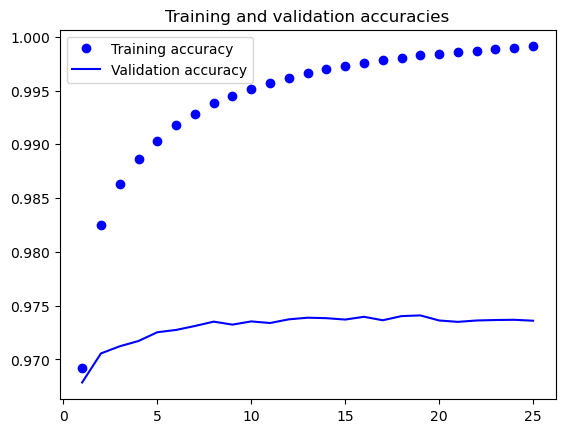

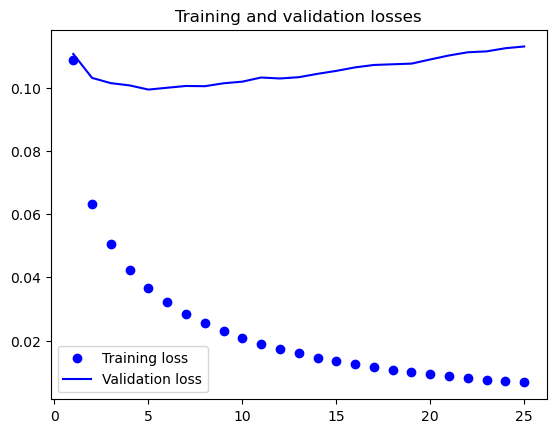

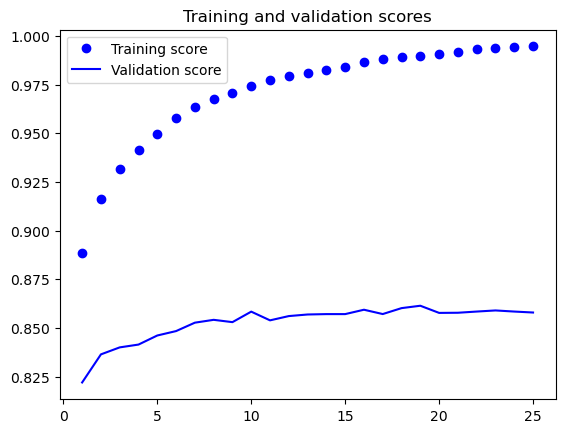

In [98]:
acc = history['accuracy']
loss = history['loss']
conll_score = history['conll_score']

val_acc = history['val_accuracy']
val_loss = history['val_loss']
val_conll_score = history['val_conll_score']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()

if CORPUS in ['CONLL2000', 'CONLL2003']:
    plt.figure()
    plt.plot(epochs, conll_score, 'bo', label='Training score')
    plt.plot(epochs, val_conll_score, 'b', label='Validation score')
    plt.title('Training and validation scores')
    plt.legend()

plt.show()

### Predicting a Value

In [99]:
model = torch.load(MODEL_FILE, weights_only=False)
model.eval()

Model(
  (word_embs): Embedding(136491, 50)
  (cap_embs): Embedding(6, 5)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=275, out_features=300, bias=True)
  (hardth): Hardtanh(min_val=-1.0, max_val=1.0)
  (relu): ReLU()
  (fc2): Linear(in_features=300, out_features=17, bias=True)
)

We set the tagger model to the best model

In [100]:
tagger.model = model

In [101]:
Y_test_pred = model(X_test)
Y_test_pred

tensor([[-16.5355, -12.6065, -10.4487,  ...,  -7.3575,  -7.5331, -10.7390],
        [-21.2702, -16.7645, -14.0689,  ..., -13.1933, -10.5316, -16.3909],
        [-20.9816, -14.3598, -15.5748,  ..., -15.2952, -21.7303, -23.9145],
        ...,
        [-27.3813, -22.3066, -16.8657,  ..., -16.7026, -24.3843, -20.2402],
        [-12.4894, -16.4256, -13.9746,  ..., -14.8802, -11.4630,  -5.4727],
        [-25.9098, -19.7733, -23.2392,  ..., -13.9702, -20.8995, -19.6334]],
       grad_fn=<AddmmBackward0>)

In [102]:
y_test_pred = torch.argmax(model(X_test), dim=-1)
y_test_pred

tensor([12, 12, 12,  ..., 12, 16, 12])

In [103]:
list(map(lambda x: idx2pos.get(x, 'UNK'),
     torch.argmax(model(X_test), dim=-1).tolist()))

['O',
 'O',
 'O',
 'S-LOC',
 'O',
 'O',
 'O',
 'O',
 'S-LOC',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'E-PER',
 'S-LOC',
 'O',
 'B-LOC',
 'I-ORG',
 'E-LOC',
 'O',
 'S-LOC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-MISC',
 'E-MISC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'S-LOC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'S-LOC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'S-LOC',
 'O',
 'S-LOC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'S-MISC',
 'O',
 'B-PER',
 'E-PER',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'S-MISC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'E-PER',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'S-MISC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-MISC',
 'E-MISC',
 'O',
 'O',
 'O',
 'O

### Testing the Model

In [104]:
loss_test, acc_test = evaluate(model, loss_fn, test_dataloader)
loss_test, acc_test

(0.10759750655260128, 0.9740924870355291)

In [105]:
target_names = sorted(pos2idx.keys(), key=lambda x: pos2idx[x])

In [106]:
target_names

['B-LOC',
 'B-MISC',
 'B-ORG',
 'B-PER',
 'E-LOC',
 'E-MISC',
 'E-ORG',
 'E-PER',
 'I-LOC',
 'I-MISC',
 'I-ORG',
 'I-PER',
 'O',
 'S-LOC',
 'S-MISC',
 'S-ORG',
 'S-PER']

In [107]:
y_test_pred[:30]

tensor([12, 12, 12, 13, 12, 12, 12, 12, 13, 12, 12, 12, 12,  3,  7, 13, 12,  0,
        10,  4, 12, 13, 12, 12, 12, 12, 12,  1,  5, 12])

In [108]:
y_test[:3]

tensor([12, 12, 12])

In [109]:
len(target_names)

17

In [110]:
pos2idx

{'B-LOC': 0,
 'B-MISC': 1,
 'B-ORG': 2,
 'B-PER': 3,
 'E-LOC': 4,
 'E-MISC': 5,
 'E-ORG': 6,
 'E-PER': 7,
 'I-LOC': 8,
 'I-MISC': 9,
 'I-ORG': 10,
 'I-PER': 11,
 'O': 12,
 'S-LOC': 13,
 'S-MISC': 14,
 'S-ORG': 15,
 'S-PER': 16}

In [111]:
print(classification_report(
    y_test_pred,
    y_test,
    digits=4,
    labels=range(len(target_names)),
    target_names=target_names,
    zero_division=0))

              precision    recall  f1-score   support

       B-LOC     0.8448    0.8066    0.8253       243
      B-MISC     0.6780    0.6186    0.6469       194
       B-ORG     0.8187    0.8103    0.8144       585
       B-PER     0.9705    0.9777    0.9741      1078
       E-LOC     0.8147    0.8217    0.8182       230
      E-MISC     0.6893    0.6321    0.6595       193
       E-ORG     0.8636    0.8117    0.8368       616
       E-PER     0.9724    0.9769    0.9746      1081
       I-LOC     0.4800    0.5714    0.5217        21
      I-MISC     0.6410    0.5319    0.5814        47
       I-ORG     0.8477    0.7806    0.8127       278
       I-PER     0.8714    0.9104    0.8905        67
           O     0.9925    0.9939    0.9932     38501
       S-LOC     0.9352    0.9249    0.9301      1452
      S-MISC     0.8038    0.8440    0.8234       500
       S-ORG     0.8669    0.8791    0.8730      1067
       S-PER     0.8719    0.9025    0.8870       513

    accuracy              

## Sentences

In [112]:
sentences = ["That round table might collapse .",
             "The man can learn well .",
             "The man can swim .",
             "The man can simwo .",
             'The Soviet Union might collapse .']

In [113]:
sd = [tagger.sent2dict(sent) for sent in sentences]
sd

[[{'ID': 1, 'FORM': 'That', 'CAPS': 'INIT_CAP'},
  {'ID': 2, 'FORM': 'round', 'CAPS': 'NO_CAPS'},
  {'ID': 3, 'FORM': 'table', 'CAPS': 'NO_CAPS'},
  {'ID': 4, 'FORM': 'might', 'CAPS': 'NO_CAPS'},
  {'ID': 5, 'FORM': 'collapse', 'CAPS': 'NO_CAPS'},
  {'ID': 6, 'FORM': '.', 'CAPS': 'NO_CAPS'}],
 [{'ID': 1, 'FORM': 'The', 'CAPS': 'INIT_CAP'},
  {'ID': 2, 'FORM': 'man', 'CAPS': 'NO_CAPS'},
  {'ID': 3, 'FORM': 'can', 'CAPS': 'NO_CAPS'},
  {'ID': 4, 'FORM': 'learn', 'CAPS': 'NO_CAPS'},
  {'ID': 5, 'FORM': 'well', 'CAPS': 'NO_CAPS'},
  {'ID': 6, 'FORM': '.', 'CAPS': 'NO_CAPS'}],
 [{'ID': 1, 'FORM': 'The', 'CAPS': 'INIT_CAP'},
  {'ID': 2, 'FORM': 'man', 'CAPS': 'NO_CAPS'},
  {'ID': 3, 'FORM': 'can', 'CAPS': 'NO_CAPS'},
  {'ID': 4, 'FORM': 'swim', 'CAPS': 'NO_CAPS'},
  {'ID': 5, 'FORM': '.', 'CAPS': 'NO_CAPS'}],
 [{'ID': 1, 'FORM': 'The', 'CAPS': 'INIT_CAP'},
  {'ID': 2, 'FORM': 'man', 'CAPS': 'NO_CAPS'},
  {'ID': 3, 'FORM': 'can', 'CAPS': 'NO_CAPS'},
  {'ID': 4, 'FORM': 'simwo', 'CAPS': 'NO_CA

In [114]:
tagger.predict_sentences(sd)

[[{'ID': 1, 'FORM': 'That', 'CAPS': 'INIT_CAP', 'PTAG': 'O'},
  {'ID': 2, 'FORM': 'round', 'CAPS': 'NO_CAPS', 'PTAG': 'O'},
  {'ID': 3, 'FORM': 'table', 'CAPS': 'NO_CAPS', 'PTAG': 'O'},
  {'ID': 4, 'FORM': 'might', 'CAPS': 'NO_CAPS', 'PTAG': 'O'},
  {'ID': 5, 'FORM': 'collapse', 'CAPS': 'NO_CAPS', 'PTAG': 'O'},
  {'ID': 6, 'FORM': '.', 'CAPS': 'NO_CAPS', 'PTAG': 'O'}],
 [{'ID': 1, 'FORM': 'The', 'CAPS': 'INIT_CAP', 'PTAG': 'O'},
  {'ID': 2, 'FORM': 'man', 'CAPS': 'NO_CAPS', 'PTAG': 'O'},
  {'ID': 3, 'FORM': 'can', 'CAPS': 'NO_CAPS', 'PTAG': 'O'},
  {'ID': 4, 'FORM': 'learn', 'CAPS': 'NO_CAPS', 'PTAG': 'O'},
  {'ID': 5, 'FORM': 'well', 'CAPS': 'NO_CAPS', 'PTAG': 'O'},
  {'ID': 6, 'FORM': '.', 'CAPS': 'NO_CAPS', 'PTAG': 'O'}],
 [{'ID': 1, 'FORM': 'The', 'CAPS': 'INIT_CAP', 'PTAG': 'O'},
  {'ID': 2, 'FORM': 'man', 'CAPS': 'NO_CAPS', 'PTAG': 'O'},
  {'ID': 3, 'FORM': 'can', 'CAPS': 'NO_CAPS', 'PTAG': 'O'},
  {'ID': 4, 'FORM': 'swim', 'CAPS': 'NO_CAPS', 'PTAG': 'O'},
  {'ID': 5, 'FORM': '.'

## Final Score

In [115]:
pred_test_sents = tagger.predict_sentences(test_dict)

In [116]:
pred_test_sents[:2]

[[{'FORM': '-DOCSTART-',
   'PPOS': '-X-',
   'PCHUNK': '-X-',
   'NER': 'O',
   'CAPS': 'ALL_CAPS',
   'PTAG': 'O'}],
 [{'FORM': 'SOCCER',
   'PPOS': 'NN',
   'PCHUNK': 'B-NP',
   'NER': 'O',
   'CAPS': 'ALL_CAPS',
   'PTAG': 'O'},
  {'FORM': '-',
   'PPOS': ':',
   'PCHUNK': 'O',
   'NER': 'O',
   'CAPS': 'NO_CAPS',
   'PTAG': 'O'},
  {'FORM': 'JAPAN',
   'PPOS': 'NNP',
   'PCHUNK': 'B-NP',
   'NER': 'S-LOC',
   'CAPS': 'ALL_CAPS',
   'PTAG': 'S-LOC'},
  {'FORM': 'GET',
   'PPOS': 'VB',
   'PCHUNK': 'B-VP',
   'NER': 'O',
   'CAPS': 'ALL_CAPS',
   'PTAG': 'O'},
  {'FORM': 'LUCKY',
   'PPOS': 'NNP',
   'PCHUNK': 'B-NP',
   'NER': 'O',
   'CAPS': 'ALL_CAPS',
   'PTAG': 'O'},
  {'FORM': 'WIN',
   'PPOS': 'NNP',
   'PCHUNK': 'I-NP',
   'NER': 'O',
   'CAPS': 'ALL_CAPS',
   'PTAG': 'O'},
  {'FORM': ',',
   'PPOS': ',',
   'PCHUNK': 'O',
   'NER': 'O',
   'CAPS': 'NO_CAPS',
   'PTAG': 'O'},
  {'FORM': 'CHINA',
   'PPOS': 'NNP',
   'PCHUNK': 'B-NP',
   'NER': 'S-PER',
   'CAPS': 'ALL_CAPS',

In [117]:
if CORPUS in ['CONLL2000', 'CONLL2003']:
    chunker_score = scorer.conll_score(pred_test_sents)
    print(f'CoNLL score on the validation set: {chunker_score:.4f}')
elif CORPUS == 'EWT':
    accuracy = scorer.accuracy(pred_test_sents)
    print(f'Accuracy on the test set: {accuracy:.4f}')

CoNLL score on the validation set: 0.8614
